<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_Titanic_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys, warnings, itertools

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, f1_score, classification_report,
                             roc_auc_score, recall_score, confusion_matrix)
from sklearn import set_config

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML

In [ ]:
%matplotlib inline

In [ ]:
def summarize_columns(df):
    num_rows = len(df)
    summary = pd.DataFrame(df.dtypes, columns=["dtypes"])
    summary = summary.reset_index()
    summary["col_name"] = summary["index"]
    summary = summary[["col_name", "dtypes"]]
    summary["missing"] = df.isnull().sum().values
    summary["missing_percent"] = summary["missing"].apply(lambda x: round(x*100/num_rows, 1))
    summary["uniques"] = df.nunique().values
    summary["first_value"] = df.iloc[0].values
    summary["second_value"] = df.iloc[1].values
    summary["third_value"] = df.iloc[2].values
    return summary

In [ ]:
def reduce_memory_usage(df, category = False):
    start_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage of dataframe is {:2f} MB!".format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            if category:
                df[col] = df[col].astype("category")
    end_mem = df.memory_usage().sum() / (1024**2)
    print("Memory usage after optimization is {:2f} MB!".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem-end_mem) / start_mem))

In [ ]:
def display_df(df, message = " "):
    print("Dataframe: {}".format(message))
    num_rows = len(df)
    num_cols = len(df.columns)
    print("num_rows = {:,} \nnum_cols = {:,}".format(num_rows, num_cols))
    display(df.head())
    print("Info:")
    print(df.info())
    df_null = df.isnull().sum()
    if len(df_null)==0:
        print("Number of null data points:",df_null[df_null!=0])
    else:
        print("Number of null data points:")
        print(df_null[df_null!=0])

In [ ]:
def plot_varibles(df, vars_to_plot, cts_vars, num_cols=2):
    num_rows = (len(vars_to_plot) // num_cols)
    if (len(vars_to_plot) % num_cols) != 0:
        num_rows += 1
    fig_size_with_subplots = (num_cols*5, num_rows*5)
    fig = plt.figure(figsize=fig_size_with_subplots)
    fig_dims = (num_rows, num_cols)
    row, col = 0, 0
    for var in vars_to_plot:
        plt.subplot2grid(fig_dims, (row, col))
        if var in cts_vars:
            df[var].hist()
            plt.title("{} Histogram".format(var))
        else:
            df[var].value_counts().plot(kind="bar", title="{} Counts".format(var))
        col += 1
        if col % num_cols == 0:
            row += 1
            col = 0

In [ ]:
@staticmethod
def display_side_by_side(dfs: list, captions: list, table_spacing=5):
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += table_spacing * "\xa0"
    display(HTML(output))

In [ ]:
def one_hot_encode(df, ohe, var_list, drop_original=True):
    temp_df = pd.DataFrame(data=ohe.transform(df[var_list]), columns=ohe.get_feature_names_out())
    df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
    if drop_original:
        df.drop(columns=var_list, axis=1, inplace=True)
    return df

In [ ]:
def plot_conf_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype("float")/ cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix no normalization")
    print(cm)
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [ ]:
curr_dir = os.getcwd()
data_dir = os.path.join(curr_dir, "titanic")
assert curr_dir == "/Users/ariahosseini/Desktop/Notebooks"
assert data_dir == "/Users/ariahosseini/Desktop/Notebooks/titanic"

In [ ]:
print("data_dir includes:", os.listdir(data_dir))

data_dir includes: ['test.csv', 'train.csv', 'gender_submission.csv']


In [ ]:
train_df = pd.read_csv(os.path.join(data_dir, "train.csv"))
display_df(train_df)

Dataframe:  
num_rows = 891 
num_cols = 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
Number of null data points:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [ ]:
reduce_memory_usage(train_df, category=True)
display_df(train_df)

Memory usage of dataframe is 0.081699 MB!
Memory usage after optimization is 0.080072 MB!
Decreased by 2.0%
Dataframe:  
num_rows = 891 
num_cols = 12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.312500,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925781,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.093750,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.046875,NaN,S


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    int8    
 2   Pclass       891 non-null    int8    
 3   Name         891 non-null    category
 4   Sex          891 non-null    category
 5   Age          714 non-null    float16 
 6   SibSp        891 non-null    int8    
 7   Parch        891 non-null    int8    
 8   Ticket       891 non-null    category
 9   Fare         891 non-null    float16 
 10  Cabin        204 non-null    category
 11  Embarked     889 non-null    category
dtypes: category(5), float16(2), int16(1), int8(4)
memory usage: 82.0 KB
None
Number of null data points:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [ ]:
summarize_columns(train_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,PassengerId,int16,0,0.0,891,1,2,3
1,Survived,int8,0,0.0,2,0,1,1
2,Pclass,int8,0,0.0,3,3,1,3
3,Name,category,0,0.0,891,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina"
4,Sex,category,0,0.0,2,male,female,female
5,Age,float16,177,19.9,88,22.0,38.0,26.0
6,SibSp,int8,0,0.0,7,1,1,0
7,Parch,int8,0,0.0,7,0,0,0
8,Ticket,category,0,0.0,681,A/5 21171,PC 17599,STON/O2. 3101282
9,Fare,float16,0,0.0,242,7.25,71.3125,7.925781


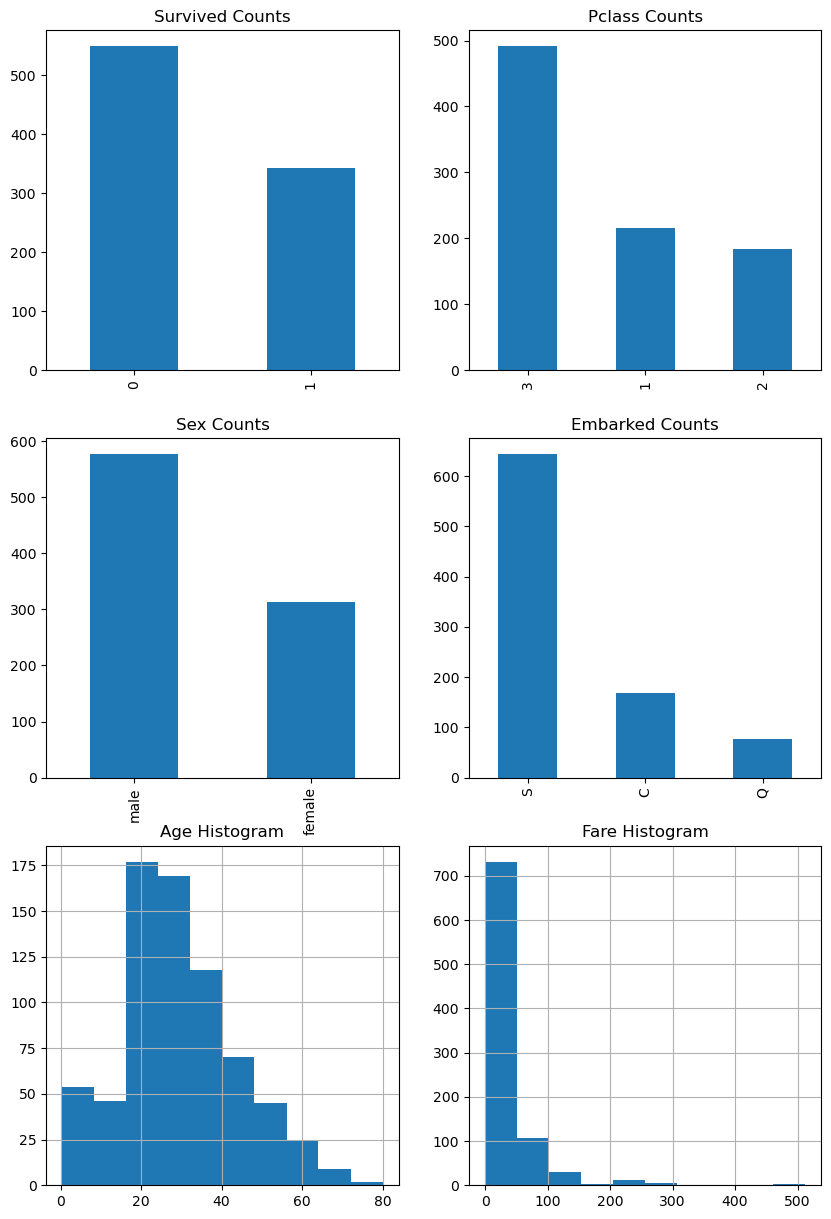

In [ ]:
vars_to_plot = ["Survived", "Pclass", "Sex", "Embarked", "Age", "Fare"]
cts_vars = ["Age", "Fare"]
plot_varibles(df=train_df, vars_to_plot=vars_to_plot, cts_vars=cts_vars, num_cols=2)

In [ ]:
vars_to_plot = ["Pclass", "Sex", "Embarked", "SibSp", "Parch"]
dfs = []
captions = []
for var in vars_to_plot:
    dfs.append(pd.crosstab(train_df[var], train_df["Survived"]))
    captions.append("Survived counts by {}".format(var))
display_side_by_side(dfs, captions, table_spacing=5)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119
Survived,0,1
Sex,,
female,81,233
male,468,109
Survived,0,1
Embarked,,


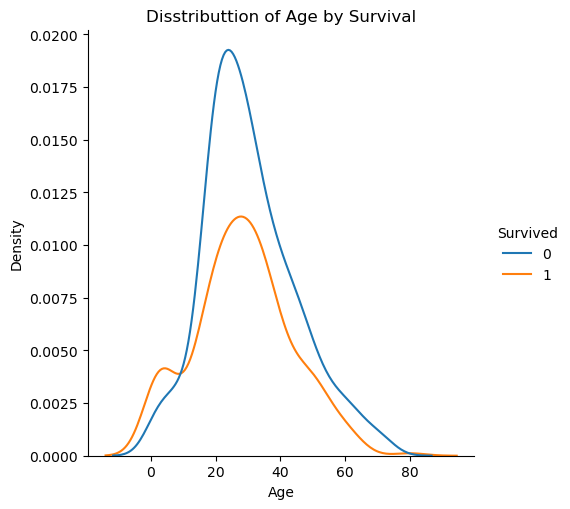

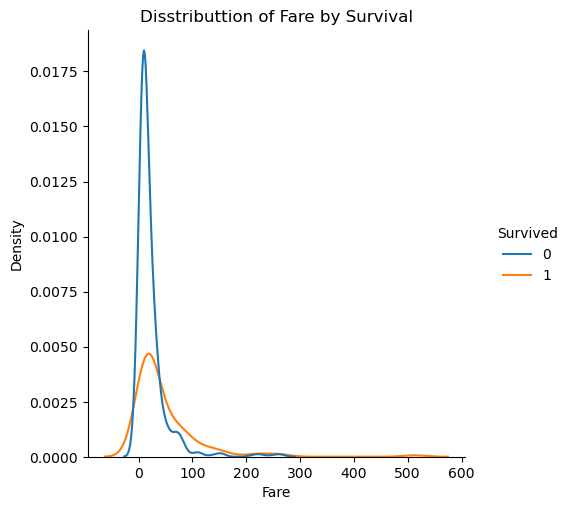

In [ ]:
cts_vars = ["Age", "Fare"]
for var in cts_vars:
    sns.displot(x=var, kind="kde", hue="Survived", data=train_df)
    plt.title("Distribution of {} by Survival".format(var))

In [ ]:
y = train_df[["Survived"]]
X = train_df.drop("Survived", axis=1)

numerical_features = ["Age", "Fare"]
categorical_features = ["Embarked", "Sex", "Pclass"]
drop_features = ["PassengerId", "Name", "Cabin", "Ticket"]
unchanged_features = ["SibSp", "Parch"]


numeric_transformer = Pipeline(steps=[("impute", SimpleImputer(strategy="median")),
                                      ("scaler", StandardScaler())
                                     ]
                              )
categorical_transformer = Pipeline(steps=[("impute", SimpleImputer(strategy="most_frequent")),
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                         ]
                                  )
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numerical_features),
                                               ("cat", categorical_transformer, categorical_features),
                                               ('drop', 'drop', drop_features),
                                               ('unchanged', 'passthrough', unchanged_features)
                                              ]
                                )
clf = Pipeline(steps=[("preprocessor", preprocessor),
                      ("classifier", RandomForestClassifier(n_estimators=100))])

set_config(display="diagram")
display(clf)
set_config(display="text")
print(clf)
print("Num of steps = {}".format(len(clf)))
print("Last step = {}".format(clf[-1]))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex',
                                                   'Pclass']),
                                                 ('drop', 'drop',
                                                  ['PassengerId', 'Name',
                                                   'Cabin', 'Ticket']),
                                                 ('unchanged', 'passthrough',
                                                  ['SibSp', 'Parch'])])),
                ('classifier', RandomForestClassifier())])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Embarked', 'Sex'

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, shuffle=True, stratify=y)
clf.fit(X_train, y_train)
score_train = clf.score(X_train, y_train)
score_val = clf.score(X_val, y_val)
print("Accuracy on traing data: {:.2f}".format(score_train))
print("Accuracy on validation data: {:.2f}".format(score_val))

Accuracy on traing data: 0.98
Accuracy on validation data: 0.81


/Applications/anaconda3/envs/PyML/lib/python3.11/site-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


In [ ]:
pred_val = clf.predict(X_val)

val_accuracy_score = accuracy_score(pred_val, y_val)
val_precision_score = precision_score(pred_val, y_val)
val_f1_score = f1_score(pred_val, y_val)
val_roc_auc_score = roc_auc_score(pred_val, y_val)
val_recall_score = recall_score(pred_val, y_val)

print("Validation Set Accuracy: {:.2f}".format(val_accuracy_score))
print("Validation Set Precision Score: {:.2f}".format(val_precision_score))
print("Validation Set F1 Score: {:.2f}".format(val_f1_score))
print("Validation Set ROC AUC Score: {:.2f}".format(val_roc_auc_score))
print("Validation Set Recall Score: {:.2f}".format(val_recall_score))

Validation Set Accuracy: 0.81
Validation Set Precision Score: 0.72
Validation Set F1 Score: 0.75
Validation Set ROC AUC Score: 0.80
Validation Set Recall Score: 0.77


In [ ]:
target_names = ["Survived", "Not Survived"]
report = classification_report(y_true=y_val, y_pred=pred_val, target_names=target_names, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Survived,0.833333,0.863636,0.848214,110.000000
Not Survived,0.769231,0.724638,0.746269,69.000000
accuracy,0.810056,0.810056,0.810056,0.810056
macro avg,0.801282,0.794137,0.797241,179.000000
weighted avg,0.808623,0.810056,0.808917,179.000000


Confusion matrix no normalization
[[95 15]
 [19 50]]


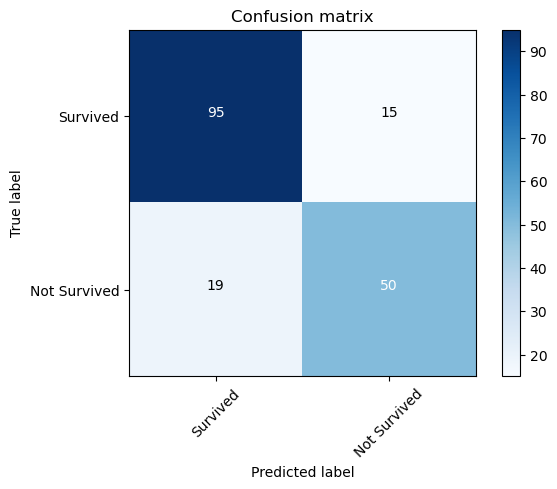

In [ ]:
cm = confusion_matrix(y_true = y_val, y_pred = pred_val)
cm_plot_labels = ["Survived", "Not Survived"]
plot_conf_matrix(cm=cm, classes=cm_plot_labels)

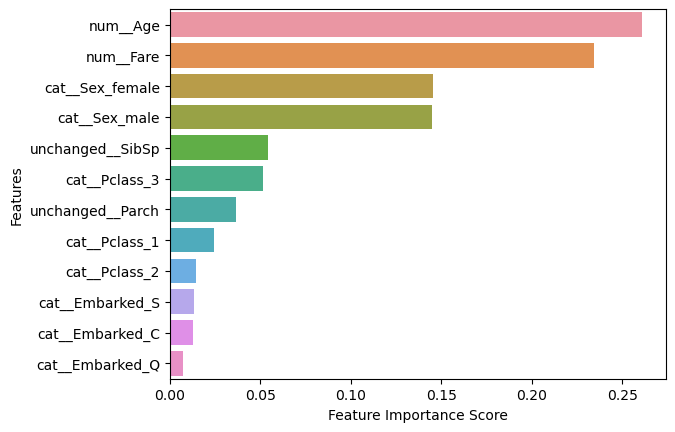

In [ ]:
feature_imp = pd.Series(clf[-1].feature_importances_,
                        index=clf[:-1].get_feature_names_out()).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

In [ ]:
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"))
display_df(test_df)

Dataframe:  
num_rows = 418 
num_cols = 11


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
Number of null data points:
Age       86
Fare       1
Cabin    327
dtype: int64


In [ ]:
reduce_memory_usage(test_df, category=True)
display_df(test_df)

Memory usage of dataframe is 0.035206 MB!
Memory usage after optimization is 0.038990 MB!
Decreased by -10.7%
Dataframe:  
num_rows = 418 
num_cols = 11


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.828125,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.000000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.687500,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.664062,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.289062,NaN,S


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int16   
 1   Pclass       418 non-null    int8    
 2   Name         418 non-null    category
 3   Sex          418 non-null    category
 4   Age          332 non-null    float16 
 5   SibSp        418 non-null    int8    
 6   Parch        418 non-null    int8    
 7   Ticket       418 non-null    category
 8   Fare         417 non-null    float16 
 9   Cabin        91 non-null     category
 10  Embarked     418 non-null    category
dtypes: category(5), float16(2), int16(1), int8(3)
memory usage: 39.9 KB
None
Number of null data points:
Age       86
Fare       1
Cabin    327
dtype: int64


In [ ]:
summarize_columns(test_df)

,col_name,dtypes,missing,missing_percent,uniques,first_value,second_value,third_value
0,PassengerId,int16,0,0.0,418,892,893,894
1,Pclass,int8,0,0.0,3,3,3,2
2,Name,category,0,0.0,418,"Kelly, Mr. James","Wilkes, Mrs. James (Ellen Needs)","Myles, Mr. Thomas Francis"
3,Sex,category,0,0.0,2,male,female,male
4,Age,float16,86,20.6,79,34.5,47.0,62.0
5,SibSp,int8,0,0.0,7,0,1,0
6,Parch,int8,0,0.0,8,0,0,0
7,Ticket,category,0,0.0,363,330911,363272,240276
8,Fare,float16,1,0.2,167,7.828125,7.0,9.6875
9,Cabin,category,327,78.2,76,NaN,NaN,NaN


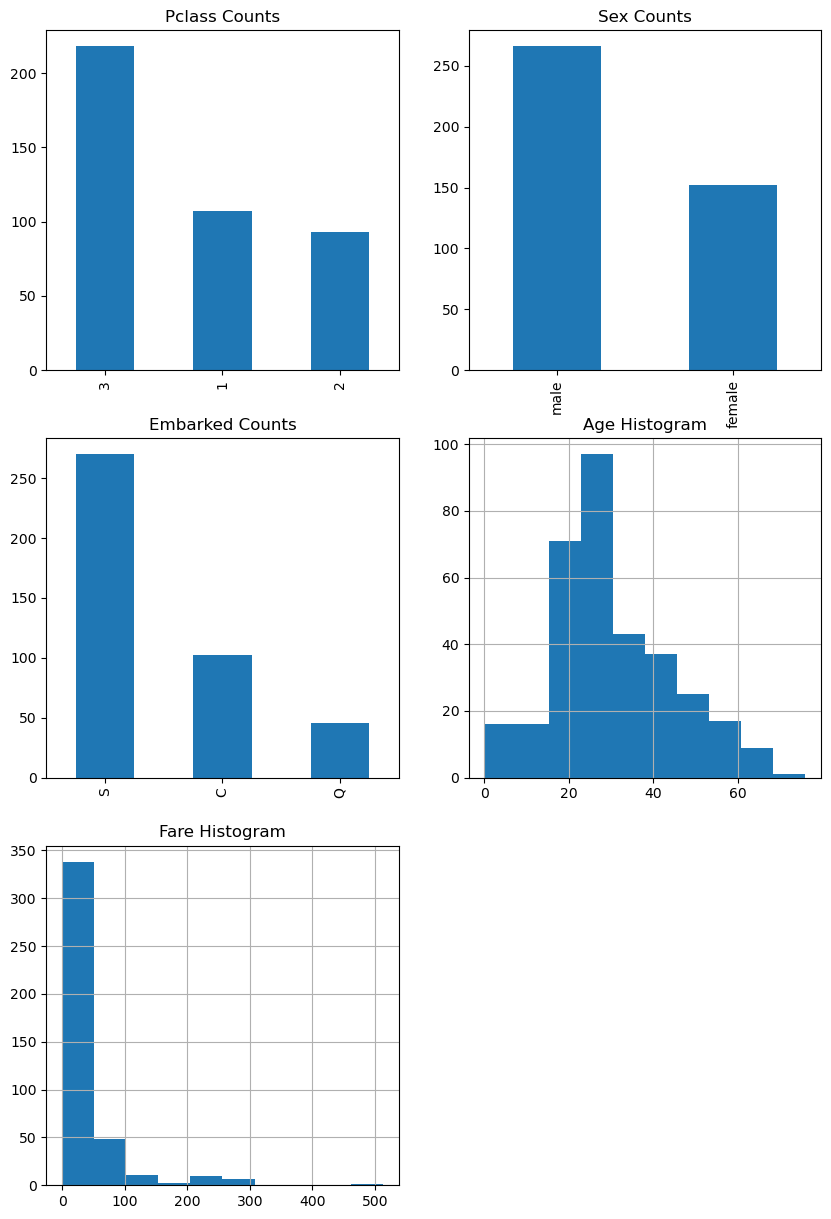

In [ ]:
vars_to_plot = ["Pclass", "Sex", "Embarked", "Age", "Fare"]
cts_vars = ["Age", "Fare"]
plot_varibles(df=test_df, vars_to_plot=vars_to_plot, cts_vars=cts_vars, num_cols=2)

In [ ]:
output_df = test_df[["PassengerId"]]

In [ ]:
X_test = test_df
y_test = clf.predict(X_test)
output_df["Survived"] = y_test
display_df(output_df)

Dataframe:  
num_rows = 418 
num_cols = 2


/var/folders/nj/n73jpv6n6n38xcx5bdfnlflh0000gn/T/ipykernel_19114/4254280306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df["Survived"] = y_test


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int16
 1   Survived     418 non-null    int8 
dtypes: int16(1), int8(1)
memory usage: 1.4 KB
None
Number of null data points:
Series([], dtype: int64)


<Axes: title={'center': 'Fare Counts'}>

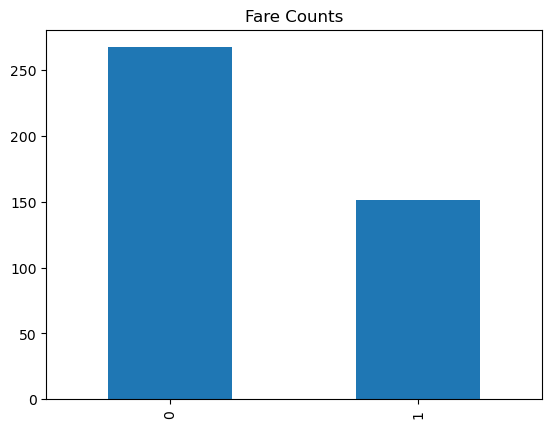

In [ ]:
output_df["Survived"].value_counts().plot(kind="bar", title="{} Counts".format(var))